# Clustering Client

In [1]:
%load_ext pycodestyle_magic

In [2]:
%pycodestyle_on

In [ ]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:50956")
client

In [4]:
import dask.array as da
import dask.dataframe as dd
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn import decomposition
from sklearn import manifold
from sklearn import metrics
from dask_ml import preprocessing


sns.set_style("whitegrid")
%matplotlib inline
warnings.filterwarnings('ignore')

## 1 - Import des jeux de données

In [7]:
data_3_months = dd.read_csv("data/clean/data_3_months.csv", parse_dates=["order_purchase_timestamp"])
data_6_months = dd.read_csv("data/clean/data_6_months.csv", parse_dates=["order_purchase_timestamp"])
data_9_months = dd.read_csv("data/clean/data_9_months.csv", parse_dates=["order_purchase_timestamp"])
data_12_months = dd.read_csv("data/clean/data_12_months.csv", parse_dates=["order_purchase_timestamp"])
data_15_months = dd.read_csv("data/clean/data_15_months.csv", parse_dates=["order_purchase_timestamp"])
data_18_months = dd.read_csv("data/clean/data_18_months.csv", parse_dates=["order_purchase_timestamp"])
data_all = dd.read_csv("data/clean/data_all.csv", parse_dates=["order_purchase_timestamp"])

2:80: E501 line too long (95 > 79 characters)
3:80: E501 line too long (95 > 79 characters)
4:80: E501 line too long (95 > 79 characters)
5:80: E501 line too long (103 > 79 characters)
6:80: E501 line too long (103 > 79 characters)
7:80: E501 line too long (103 > 79 characters)
8:80: E501 line too long (91 > 79 characters)


## 2 - Features engineering

In [9]:
def review(df):
    grouped = df.groupby("customer_unique_id").agg({"review_score": ["count", "min", "max", "mean"]})
    grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
    return grouped


def value(df):
    grouped = df.groupby("customer_unique_id").agg({
        "payment_value": ["mean", "min", "max"]})
    grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
    return grouped


def payment_facility(df):
    df_pf = df.groupby("customer_unique_id").agg({
        "payment_installments": "sum"
    })
    cond_mask = (df_pf["payment_installments"] > 1)

    df_pf["payment_installments"] = df_pf["payment_installments"].mask(cond=cond_mask, other=0)
    df_pf = df_pf.rename(columns={"payment_installments": "payment_facility"})
    return df_pf


def category_transf(df):
    df_ct = dd.get_dummies(df[["product_category_name", "customer_unique_id"]].categorize(), columns=['product_category_name'], prefix="PCat").groupby(['customer_unique_id']).sum()
    return df_ct


def state(df):
    df_state = dd.get_dummies(df[["customer_state", "customer_unique_id"]].categorize(), columns=["customer_state"], prefix="CState").groupby(["customer_unique_id"]).sum()
    return df_state


def payment(df):
    df_p = dd.get_dummies(df[["payment_type", "customer_unique_id"]].categorize(), columns=['payment_type'], prefix="PType").groupby(['customer_unique_id']).sum()
    return df_p


def rfm(df):
    df = df.compute()
    return df.groupby("customer_unique_id").agg(
        recency=("order_purchase_timestamp", lambda date: (df["order_purchase_timestamp"].max() - date.max()).days),
        frequency=("order_id", "count"),
        monetary=("payment_value", sum))


def features_engineering(df):
    df_fe = dd.merge(rfm(df), value(df))
    df_fe = dd.merge(df_fe, review(df))
    df_fe = dd.merge(df_fe, payment(df))
    df_fe = dd.merge(df_fe, state(df))
    df_fe = dd.merge(df_fe, category_transf(df))
    df_fe = dd.merge(df_fe, payment_facility(df))
    return df_fe

2:80: E501 line too long (101 > 79 characters)
20:80: E501 line too long (95 > 79 characters)
26:80: E501 line too long (180 > 79 characters)
31:80: E501 line too long (171 > 79 characters)
36:80: E501 line too long (162 > 79 characters)
43:80: E501 line too long (116 > 79 characters)


In [5]:
data_3_months_fe = features_engineering(data_3_months).compute()
data_3_months_fe.head()

,recency,frequency,monetary,payment_value_mean,payment_value_min,payment_value_max,review_score_count,review_score_min,review_score_max,review_score_mean,...,PCat_fashion_underwear_beach,PCat_books_technical,PCat_dvds_blu_ray,PCat_security_and_services,PCat_tablets_printing_image,PCat_furniture_bedroom,PCat_cine_photo,PCat_fashio_female_clothing,PCat_books_imported,payment_facility
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,20,1,86.22,86.22,86.22,86.22,1,3,3,3.0,...,0,0,0,0,0,0,0,0,0,0
0005e1862207bf6ccc02e4228effd9a0,26,1,150.12,150.12,150.12,150.12,1,4,4,4.0,...,0,0,0,0,0,0,0,0,0,0
00115fc7123b5310cf6d3a3aa932699e,68,1,76.11,76.11,76.11,76.11,1,4,4,4.0,...,0,0,0,0,0,0,0,0,0,1
001f3c4211216384d5fe59b041ce1461,11,1,35.84,35.84,35.84,35.84,1,3,3,3.0,...,0,0,0,0,0,0,0,0,0,0
002043098f10ba39a4600b6c52fbfe3c,4,1,237.81,237.81,237.81,237.81,1,4,4,4.0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
data_6_months_fe = features_engineering(data_6_months).compute()
data_6_months_fe.head()

,recency,frequency,monetary,payment_value_mean,payment_value_min,payment_value_max,review_score_count,review_score_min,review_score_max,review_score_mean,...,PCat_books_technical,PCat_dvds_blu_ray,PCat_security_and_services,PCat_tablets_printing_image,PCat_furniture_bedroom,PCat_cine_photo,PCat_fashio_female_clothing,PCat_books_imported,PCat_la_cuisine,payment_facility
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,111,1,86.22,86.22,86.22,86.22,1,3,3,3.0,...,0,0,0,0,0,0,0,0,0,0
0005e1862207bf6ccc02e4228effd9a0,116,1,150.12,150.12,150.12,150.12,1,4,4,4.0,...,0,0,0,0,0,0,0,0,0,0
00115fc7123b5310cf6d3a3aa932699e,159,1,76.11,76.11,76.11,76.11,1,4,4,4.0,...,0,0,0,0,0,0,0,0,0,1
0011805441c0d1b68b48002f1d005526,66,1,297.14,297.14,297.14,297.14,1,3,3,3.0,...,0,0,0,0,0,0,0,0,0,0
0011857aff0e5871ce5eb429f21cdaf5,1,1,192.83,192.83,192.83,192.83,1,5,5,5.0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
data_9_months_fe = features_engineering(data_9_months).compute()
data_9_months_fe.head()

,recency,frequency,monetary,payment_value_mean,payment_value_min,payment_value_max,review_score_count,review_score_min,review_score_max,review_score_mean,...,PCat_dvds_blu_ray,PCat_cds_dvds_musicals,PCat_security_and_services,PCat_tablets_printing_image,PCat_furniture_bedroom,PCat_cine_photo,PCat_fashio_female_clothing,PCat_books_imported,PCat_la_cuisine,payment_facility
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,203,1,86.22,86.22,86.22,86.22,1,3,3,3.0,...,0,0,0,0,0,0,0,0,0,0
0005e1862207bf6ccc02e4228effd9a0,209,1,150.12,150.12,150.12,150.12,1,4,4,4.0,...,0,0,0,0,0,0,0,0,0,0
0006fdc98a402fceb4eb0ee528f6a8d4,73,1,29.00,29.00,29.00,29.00,1,3,3,3.0,...,0,0,0,0,0,0,0,0,0,0
000a5ad9c4601d2bbdd9ed765d5213b3,49,1,91.28,91.28,91.28,91.28,1,4,4,4.0,...,0,0,0,0,0,0,0,0,0,0
000bfa1d2f1a41876493be685390d6d3,0,2,93.70,46.85,46.85,46.85,2,4,5,4.5,...,0,0,0,0,0,0,0,0,0,0


In [8]:
data_12_months_fe = features_engineering(data_12_months).compute()
data_12_months_fe.head()

,recency,frequency,monetary,payment_value_mean,payment_value_min,payment_value_max,review_score_count,review_score_min,review_score_max,review_score_mean,...,PCat_cds_dvds_musicals,PCat_security_and_services,PCat_tablets_printing_image,PCat_furniture_bedroom,PCat_cine_photo,PCat_fashio_female_clothing,PCat_diapers_and_hygiene,PCat_books_imported,PCat_la_cuisine,payment_facility
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,295,1,86.22,86.22,86.22,86.22,1,3,3,3.0,...,0,0,0,0,0,0,0,0,0,0
0000f6ccb0745a6a4b88665a16c9f078,79,1,43.62,43.62,43.62,43.62,1,4,4,4.0,...,0,0,0,0,0,0,0,0,0,0
0004aac84e0df4da2b147fca70cf8255,46,1,196.89,196.89,196.89,196.89,1,5,5,5.0,...,0,0,0,0,0,0,0,0,0,0
0005e1862207bf6ccc02e4228effd9a0,301,1,150.12,150.12,150.12,150.12,1,4,4,4.0,...,0,0,0,0,0,0,0,0,0,0
0006fdc98a402fceb4eb0ee528f6a8d4,165,1,29.00,29.00,29.00,29.00,1,3,3,3.0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
data_15_months_fe = features_engineering(data_15_months).compute()
data_15_months_fe.head()

,recency,frequency,monetary,payment_value_mean,payment_value_min,payment_value_max,review_score_count,review_score_min,review_score_max,review_score_mean,...,PCat_cds_dvds_musicals,PCat_security_and_services,PCat_tablets_printing_image,PCat_furniture_bedroom,PCat_cine_photo,PCat_fashio_female_clothing,PCat_diapers_and_hygiene,PCat_books_imported,PCat_la_cuisine,payment_facility
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,385,1,86.22,86.22,86.22,86.22,1,3,3,3.0,...,0,0,0,0,0,0,0,0,0,0
0000f6ccb0745a6a4b88665a16c9f078,169,1,43.62,43.62,43.62,43.62,1,4,4,4.0,...,0,0,0,0,0,0,0,0,0,0
0004aac84e0df4da2b147fca70cf8255,136,1,196.89,196.89,196.89,196.89,1,5,5,5.0,...,0,0,0,0,0,0,0,0,0,0
00053a61a98854899e70ed204dd4bafe,30,2,838.36,419.18,419.18,419.18,2,1,1,1.0,...,0,0,0,0,0,0,0,0,0,0
0005e1862207bf6ccc02e4228effd9a0,391,1,150.12,150.12,150.12,150.12,1,4,4,4.0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
data_18_months_fe = features_engineering(data_18_months).compute()
data_18_months_fe.head()

,recency,frequency,monetary,payment_value_mean,payment_value_min,payment_value_max,review_score_count,review_score_min,review_score_max,review_score_mean,...,PCat_cds_dvds_musicals,PCat_security_and_services,PCat_tablets_printing_image,PCat_furniture_bedroom,PCat_cine_photo,PCat_fashio_female_clothing,PCat_diapers_and_hygiene,PCat_books_imported,PCat_la_cuisine,payment_facility
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,50,1,141.90,141.90,141.90,141.90,1,5,5,5.0,...,0,0,0,0,0,0,0,0,0,0
0000b849f77a49e4a4ce2b2a4ca5be3f,53,1,27.19,27.19,27.19,27.19,1,4,4,4.0,...,0,0,0,0,0,0,0,0,0,1
0000f46a3911fa3c0805444483337064,476,1,86.22,86.22,86.22,86.22,1,3,3,3.0,...,0,0,0,0,0,0,0,0,0,0
0000f6ccb0745a6a4b88665a16c9f078,260,1,43.62,43.62,43.62,43.62,1,4,4,4.0,...,0,0,0,0,0,0,0,0,0,0
0004aac84e0df4da2b147fca70cf8255,227,1,196.89,196.89,196.89,196.89,1,5,5,5.0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
data_all_fe = features_engineering(data_all).compute()
data_all_fe.head()

,recency,frequency,monetary,payment_value_mean,payment_value_min,payment_value_max,review_score_count,review_score_min,review_score_max,review_score_mean,...,PCat_cds_dvds_musicals,PCat_security_and_services,PCat_tablets_printing_image,PCat_furniture_bedroom,PCat_cine_photo,PCat_fashio_female_clothing,PCat_diapers_and_hygiene,PCat_books_imported,PCat_la_cuisine,payment_facility
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,141.90,141.90,141.90,1,5,5,5.0,...,0,0,0,0,0,0,0,0,0,0
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,27.19,27.19,27.19,1,4,4,4.0,...,0,0,0,0,0,0,0,0,0,1
0000f46a3911fa3c0805444483337064,541,1,86.22,86.22,86.22,86.22,1,3,3,3.0,...,0,0,0,0,0,0,0,0,0,0
0000f6ccb0745a6a4b88665a16c9f078,325,1,43.62,43.62,43.62,43.62,1,4,4,4.0,...,0,0,0,0,0,0,0,0,0,0
0004aac84e0df4da2b147fca70cf8255,292,1,196.89,196.89,196.89,196.89,1,5,5,5.0,...,0,0,0,0,0,0,0,0,0,0


On enregistre les jeux de données pour revenir dessus plus tard

In [35]:
data_3_months_fe.to_csv("data/fe/data_3_months.csv")
data_6_months_fe.to_csv("data/fe/data_6_months.csv")
data_9_months_fe.to_csv("data/fe/data_9_months.csv")
data_12_months_fe.to_csv("data/fe/data_12_months.csv")
data_15_months_fe.to_csv("data/fe/data_15_months.csv")
data_18_months_fe.to_csv("data/fe/data_18_months.csv")
data_all_fe.to_csv("data/fe/data_all.csv")

## 3 - Préparation

### 3.1 - Import des jeux de donnée après features engineering

In [10]:
data_3_months = pd.read_csv("data/fe/data_3_months.csv", index_col="customer_unique_id")
data_6_months = pd.read_csv("data/fe/data_6_months.csv", index_col="customer_unique_id")
data_9_months = pd.read_csv("data/fe/data_9_months.csv", index_col="customer_unique_id")
data_12_months = pd.read_csv("data/fe/data_12_months.csv", index_col="customer_unique_id")
data_15_months = pd.read_csv("data/fe/data_15_months.csv", index_col="customer_unique_id")
data_18_months = pd.read_csv("data/fe/data_18_months.csv", index_col="customer_unique_id")
data_all = pd.read_csv("data/fe/data_all.csv", index_col="customer_unique_id")

1:80: E501 line too long (88 > 79 characters)
2:80: E501 line too long (88 > 79 characters)
3:80: E501 line too long (88 > 79 characters)
4:80: E501 line too long (90 > 79 characters)
5:80: E501 line too long (90 > 79 characters)
6:80: E501 line too long (90 > 79 characters)


### 3.2 - Normalisation

In [12]:
standardize = preprocessing.StandardScaler()
standardize.fit(data_3_months.iloc[:])
data_3_months = standardize.transform(data_3_months.iloc[:])

### 3.3 - Déclaration des fonctions

In [18]:
def best_cluster_kmean(data, title):
    km_cluster_number = []
    km_score = []
    for n in range(2, 25):
        kmean = KMeans(n_clusters=n, n_init=100, max_iter=3000)
        kmean.fit(data)
        km_cluster_number.append(n)
        km_score.append(silhouette_score(data, kmean.labels_, metric='euclidean'))
    plt.figure(figsize=(10, 5))
    plt.plot(km_cluster_number, km_score, color="skyblue", lw=2)
    plt.xlabel("Nombre de cluster")
    plt.ylabel("Score de silhouette")
    plt.title("{} Kmean".format(title))
    plt.tight_layout()
    plt.show()


def best_cluster_hier(data, title):
    hier_cluster_number = []
    hier_score = []
    for n in range(2, 25):
        clust_hier = AgglomerativeClustering(n_clusters=n)
        clust_hier.fit(data)
        hier_cluster_number.append(n)
        hier_score.append(silhouette_score(data, clust_hier.labels_, metric="euclidean"))
    plt.figure(figsize=(10, 5))
    plt.plot(hier_cluster_number, hier_score, color="skyblue", lw=2)
    plt.xlabel("Nombre de cluster")
    plt.ylabel("Score de silhouette")
    plt.title("{} Clustering Hierarchique".format(title))
    plt.tight_layout()
    plt.show()


def kmean_labels(n_clusters, fit_var):
    kmean = KMeans(n_clusters=n_clusters, n_init=100, max_iter=3000)
    kmean.fit(fit_var)
    return kmean.labels_


def kpca_projected(n_components, fit_var):
    kpca = decomposition.KernelPCA(n_components=n_components, kernel="cosine")
    return kpca.fit_transform(fit_var)


def isomap_projected(fit_var):
    isomap = manifold.Isomap(n_components=2, n_jobs=-1)
    return isomap.fit_transform(fit_var)


def tsne_projected(fit_var):
    tsne = manifold.TSNE(n_components=2, perplexity=70)
    return tsne.fit_transform(fit_var)


def pca_projected(n_components, fit_var):
    pca = decomposition.PCA(n_components=n_components)
    return pca.fit_transform(fit_var)


def mds_projected(fit_var):
    mds = manifold.MDS(n_components=2)
    return mds.fit_transform(fit_var)


def plot_with_tsne(fit_var, labels):
    tsne = manifold.TSNE(n_components=2, perplexity=70)
    X_tsne = tsne.fit_transform(fit_var)
    plt.figure(figsize=(10, 5))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], marker='.',  c=labels, cmap=plt.get_cmap("tab20"))
    plt.tight_layout()
    plt.show()

8:80: E501 line too long (82 > 79 characters)
25:80: E501 line too long (89 > 79 characters)
70:80: E501 line too long (94 > 79 characters)


## 4 - Clustering

### 4.1 - K-means (Baseline)

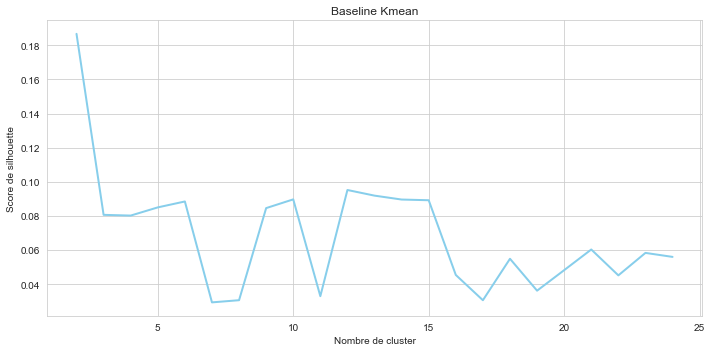

In [5]:
best_cluster_kmean(data_3_months, "Baseline")

### 4.2 - DBSCAN (Baseline)

In [6]:
dbscan_clust = DBSCAN(eps=0.8, min_samples=10)
dbscan_clust.fit(data_3_months)

DBSCAN(algorithm='auto', eps=0.8, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=10, n_jobs=None, p=None)

In [7]:
dbscan_labels = dbscan_clust.labels_

In [8]:
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_clusters

19

In [9]:
silhouette_score(data_3_months, dbscan_labels)

-0.35095667658863056

In [10]:
list(dbscan_labels).count(-1)

4506

### 4.3 - Clustering Hierarchique (Baseline)

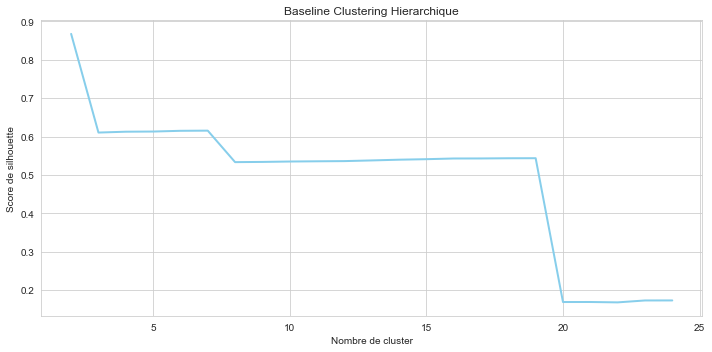

In [11]:
best_cluster_hier(data_3_months, "Baseline")

## 5- Réduction de dimension

In [5]:
X = data_3_months.values

### 5.1 - Linear PCA
#### 5.1.1 - Decomposition et projection

In [13]:
pca = decomposition.PCA(n_components=94)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=94, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

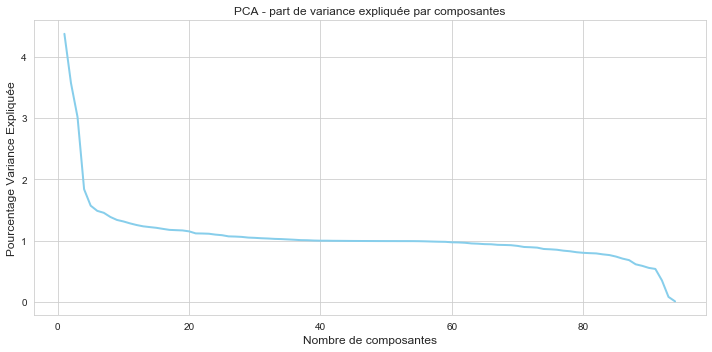

In [14]:
components = range(1, len(pca.explained_variance_ratio_) + 1)
plt.figure(figsize=(10, 5))
plt.plot(components, pca.explained_variance_ratio_*100, color='skyblue', lw=2)
plt.xlabel('Nombre de composantes', fontsize=12)
plt.ylabel('Pourcentage Variance Expliquée', fontsize=12)
plt.title('PCA - part de variance expliquée par composantes')
plt.tight_layout()
plt.show()

In [15]:
X_pca_projected = pca_projected(10, X)

#### 5.1.2 - Clustering
##### 5.1.2.1 - K-means

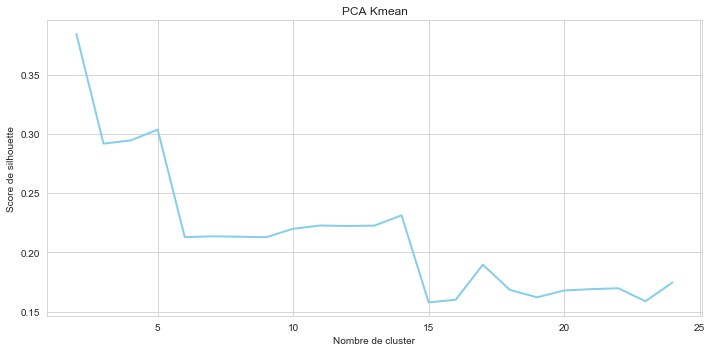

In [16]:
best_cluster_kmean(X_pca_projected, "PCA")

##### 5.1.2.2 - Clustering Hierarchique

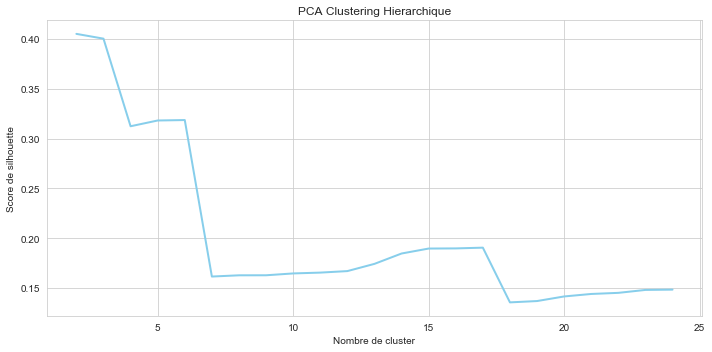

In [17]:
best_cluster_hier(X_pca_projected, "PCA")

### 5.2 -  Kernel PCA
#### 5.2.1 - Decomposition et projection

In [8]:
kpca = decomposition.KernelPCA(n_components=X.shape[1], kernel="cosine")
kpca.fit(X)

KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
          fit_inverse_transform=False, gamma=None, kernel='cosine',
          kernel_params=None, max_iter=None, n_components=101, n_jobs=None,
          random_state=None, remove_zero_eig=False, tol=0)

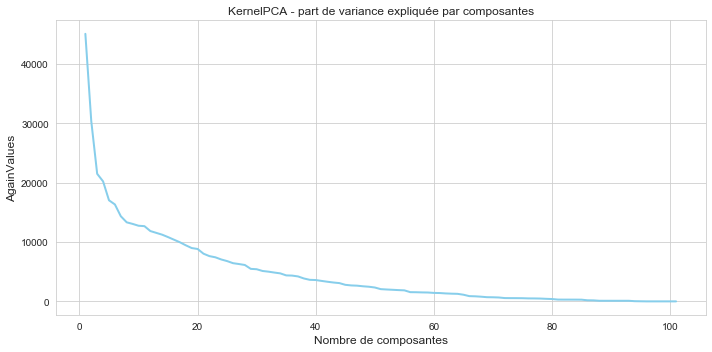

In [9]:
components = range(1, len(kpca.lambdas_)+1)
plt.figure(figsize=(10, 5))
plt.plot(components, kpca.lambdas_*100, color='skyblue', lw=2)
plt.xlabel('Nombre de composantes', fontsize=12)
plt.ylabel('AgainValues', fontsize=12)
plt.title('KernelPCA - part de variance expliquée par composantes')
plt.tight_layout()
plt.show()

In [10]:
X_kpca_projected = kpca_projected(10, X)

#### 5.2.2 - Clustering
##### 5.2.2.1 - K-means

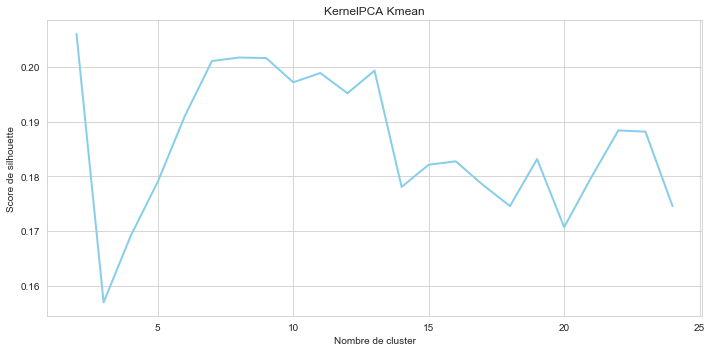

In [11]:
best_cluster_kmean(X_kpca_projected, "KernelPCA")

##### 5.2.2.2 - Clustering Hierarchique

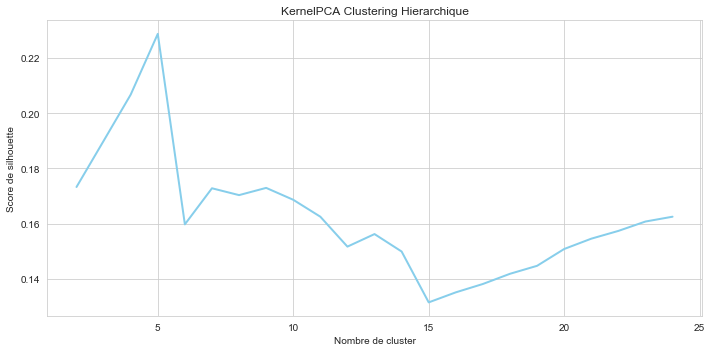

In [12]:
best_cluster_hier(X_kpca_projected, "KernelPCA")

### 5.3 - T-SNE
#### 5.3.1 - Decomposition et projection

In [23]:
X_tsne = tsne_projected(X)

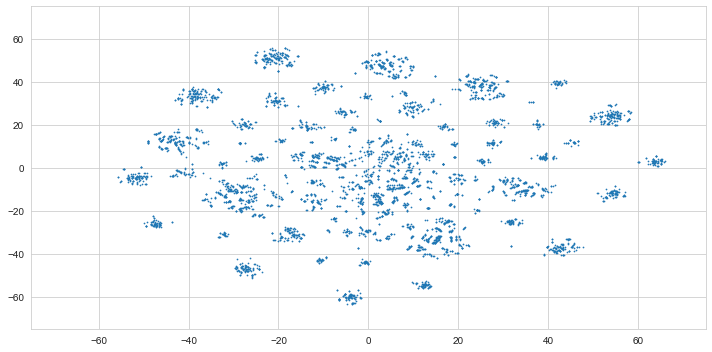

In [24]:
plt.figure(figsize=(10, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=0.5)
plt.xlim(-75, 75)
plt.ylim(-75, 75)
plt.tight_layout()
plt.show()

#### 5.3.2 - Clustering
##### 5.3.2.1 - K-means

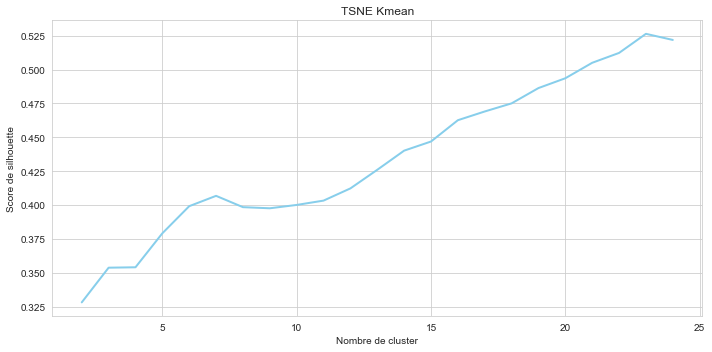

In [25]:
best_cluster_kmean(X_tsne, "TSNE")

##### 5.3.2.2 - Clustering Hierarchique

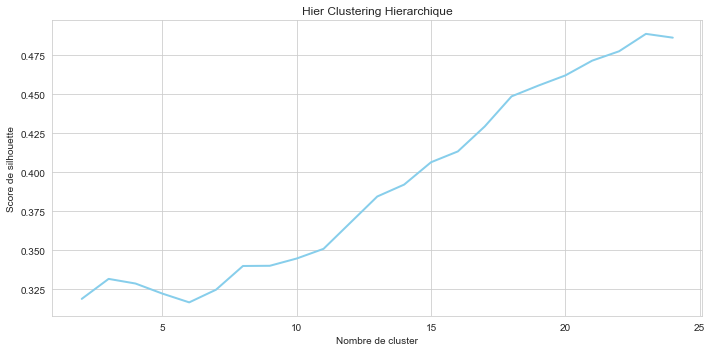

In [26]:
best_cluster_hier(X_tsne, "Hier")

### 5.4 - MDS
#### 5.4.1 - Decomposition et projection

In [27]:
X_mds = mds_projected(X)

#### 5.4.2 - Clustering
##### 5.4.2.1 - K-means

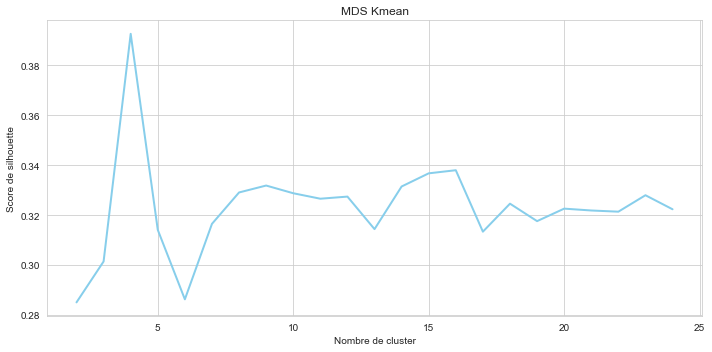

In [28]:
best_cluster_kmean(X_mds, "MDS")

##### 5.4.2.2 - Clustering Hierarchique

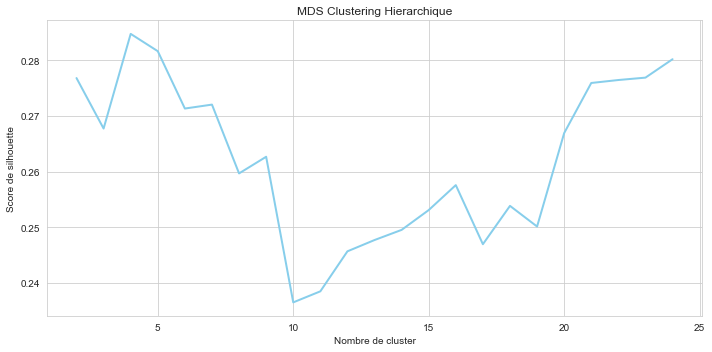

In [29]:
best_cluster_hier(X_mds, "MDS")

### 5.5 - ISO Map
#### 5.5.1 - Decomposition et projection

In [30]:
X_isomap = isomap_projected(X)

#### 5.5.2 - Clustering
##### 5.5.2.1 - K-means

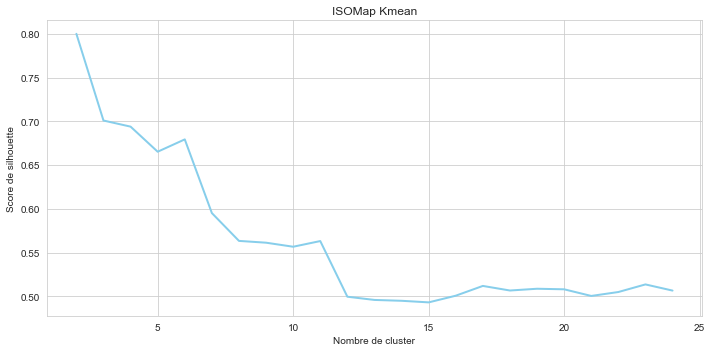

In [31]:
best_cluster_kmean(X_isomap, "ISOMap")

##### 5.5.2.2 - Clustering Hierarchique

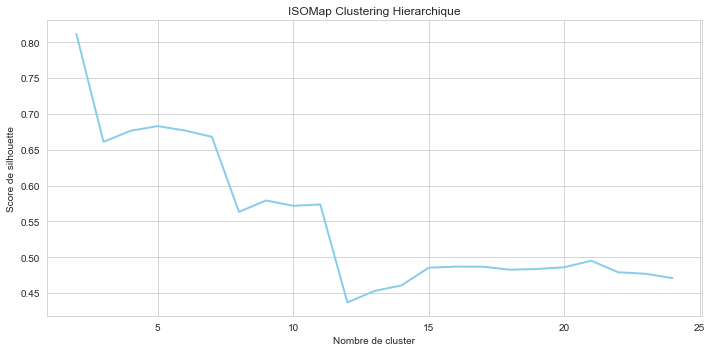

In [32]:
best_cluster_hier(X_isomap, "ISOMap")

## 6 - Choix du meilleur modèle

### 6.1 - KernelPCA (10 composantes) puis KMeans avec 8 Clusters

In [13]:
X_kpca_projected = kpca_projected(10, X)

In [14]:
data_3_months['cluster_kpca_km'] = kmean_labels(8, X_kpca_projected)

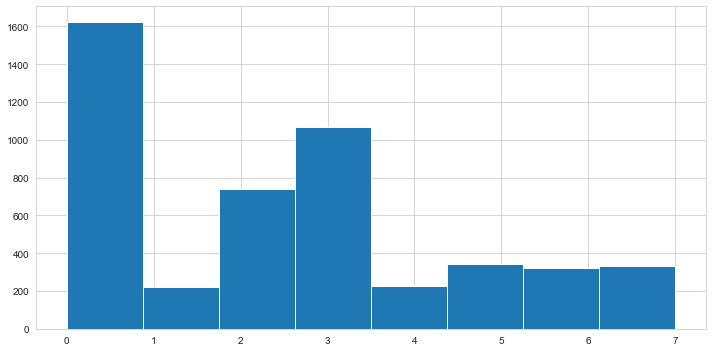

In [15]:
plt.figure(figsize=(10, 5))
plt.hist(data_3_months['cluster_kpca_km'], bins=8)
plt.tight_layout()
plt.show()

In [16]:
print('taille cluster max: {}'.format(max(data_3_months.groupby(['cluster_kpca_km']).size())))
print('taille cluster min: {}'.format(min(data_3_months.groupby(['cluster_kpca_km']).size())))

taille cluster max: 1625
taille cluster min: 219


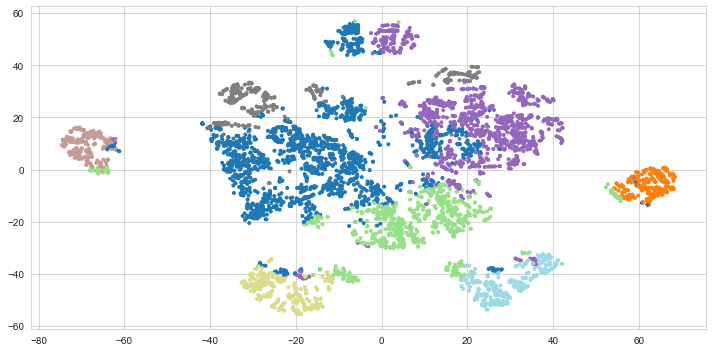

In [17]:
plot_with_tsne(X_kpca_projected, data_3_months["cluster_kpca_km"])

### 6.2 - ISOMap (2 composantes) puis KMeans avec 6 Clusters

In [18]:
X_isomap = isomap_projected(X)

In [19]:
data_3_months['cluster_iso_km'] = kmean_labels(6, X_isomap)

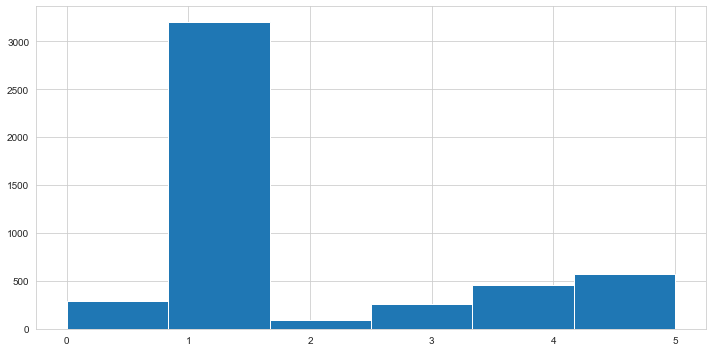

In [20]:
plt.figure(figsize=(10, 5))
plt.hist(data_3_months['cluster_iso_km'], bins=6)
plt.tight_layout()
plt.show()

In [21]:
print('taille cluster max: {}'.format(max(data_3_months.groupby(['cluster_iso_km']).size())))
print('taille cluster min: {}'.format(min(data_3_months.groupby(['cluster_iso_km']).size())))

taille cluster max: 3205
taille cluster min: 92


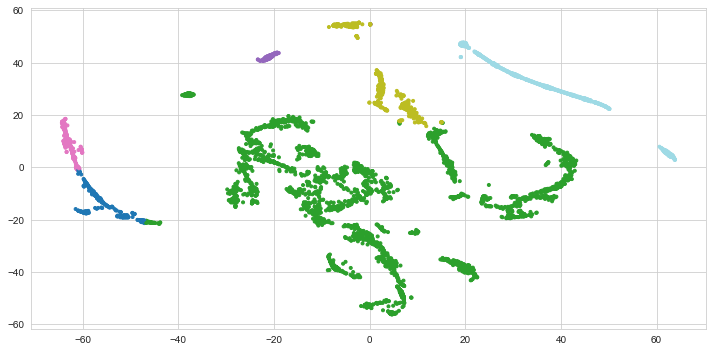

In [22]:
plot_with_tsne(X_isomap, data_3_months["cluster_iso_km"])

### 6.3 - TSNE (2 composantes) puis KMeans avec 16 Clusters

In [23]:
X_tsne = tsne_projected(X)

In [24]:
data_3_months['cluster_tsne_km'] = kmean_labels(16, X_tsne)

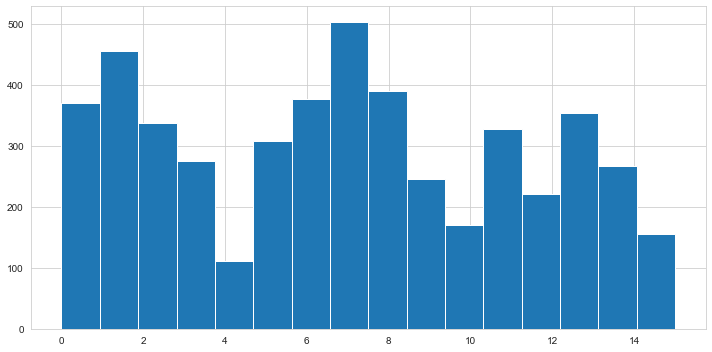

In [25]:
plt.figure(figsize=(10, 5))
plt.hist(data_3_months['cluster_tsne_km'], bins=16)
plt.tight_layout()
plt.show()

In [26]:
print('taille cluster max: {}'.format(max(data_3_months.groupby(['cluster_tsne_km']).size())))
print('taille cluster min: {}'.format(min(data_3_months.groupby(['cluster_tsne_km']).size())))

taille cluster max: 504
taille cluster min: 111


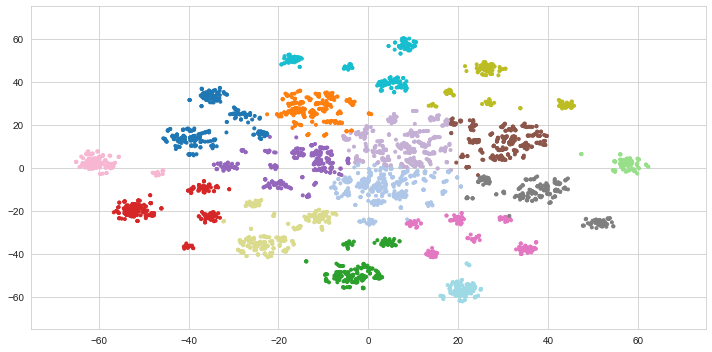

In [27]:
plt.figure(figsize=(10, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], marker='.', c=data_3_months['cluster_tsne_km'], cmap=plt.get_cmap("tab20"))
plt.xlim(-75, 75)
plt.ylim(-75, 75)
plt.tight_layout()
plt.show()

### 6.4 - PCA (50) + TSNE (2) avec KMeans (16 Clusters)

In [28]:
X_pca_projected = pca_projected(50, X)

In [29]:
X_tsne = tsne_projected(X_pca_projected)

In [30]:
data_3_months['cluster_pca_tsne_km'] = kmean_labels(16, X_tsne)

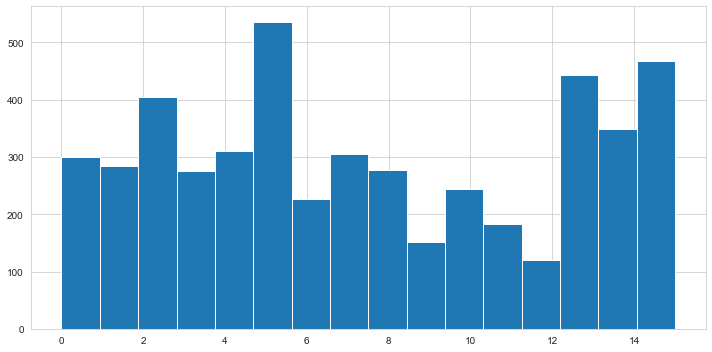

In [31]:
plt.figure(figsize=(10, 5))
plt.hist(data_3_months['cluster_pca_tsne_km'], bins=16)
plt.tight_layout()
plt.show()

In [32]:
print('taille cluster max: {}'.format(max(data_3_months.groupby(['cluster_pca_tsne_km']).size())))
print('taille cluster min: {}'.format(min(data_3_months.groupby(['cluster_pca_tsne_km']).size())))

taille cluster max: 536
taille cluster min: 120


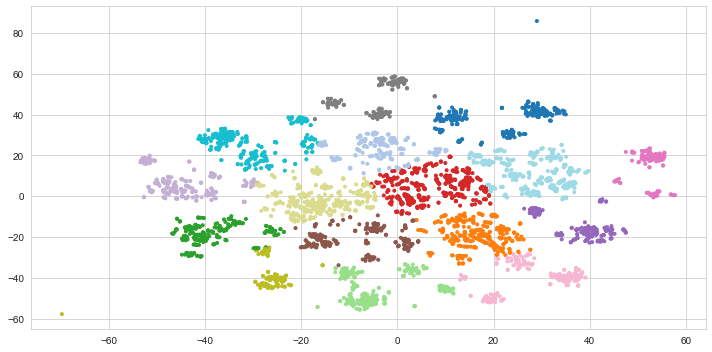

In [33]:
plt.figure(figsize=(10, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], marker='.', c=data_3_months['cluster_pca_tsne_km'], cmap=plt.get_cmap("tab20"))
plt.tight_layout()
plt.show()

In [34]:
data_3_months = data_3_months.drop(columns=["cluster_tsne_km", "cluster_iso_km", "cluster_pca_tsne_km", "cluster_tsne_km"])

In [35]:
from math import pi
categories = ["recency", "frequency", "monetary", "payment_value_mean", "review_score_mean"]
values = data_3_months[categories].mean().values.flatten().tolist()
values += values[:1]

angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

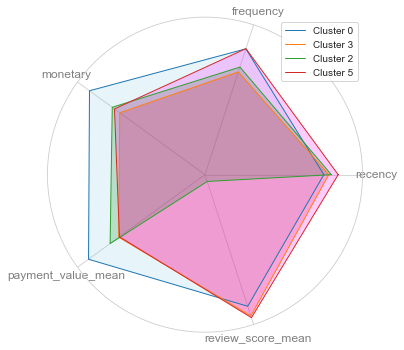

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), subplot_kw=(dict(polar=True)))

plt.xticks(angles[:-1], categories, color='grey', size=12)
plt.yticks(np.arange(1,6), ["1", "2", "3", "4", "5"], color='grey', size=12)
ax.set_rlabel_position(30)
color_rad = ["skyblue", "red", "green", "magenta", "orange"]

for i, idx in enumerate(data_3_months["cluster_kpca_km"].value_counts().nlargest(4).index):
    val = data_3_months.groupby("cluster_kpca_km").mean().loc[idx][categories].tolist()
    val += val[:1]
    ax.plot(angles, val, lw=1, ls='solid', label="Cluster {}".format(idx))
    ax.fill(angles, val, color_rad[i], alpha=0.2)
    
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [37]:
data_result = pd.DataFrame(index=data_all.index)

In [38]:
data_result['cluster_3_months'] = data_3_months['cluster_kpca_km']
data_result

,cluster_3_months
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,NaN
0000b849f77a49e4a4ce2b2a4ca5be3f,NaN
0000f46a3911fa3c0805444483337064,0.0
0000f6ccb0745a6a4b88665a16c9f078,NaN
0004aac84e0df4da2b147fca70cf8255,NaN
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,NaN
fffea47cd6d3cc0a88bd621562a9d061,NaN
ffff371b4d645b6ecea244b27531430a,3.0


## 7 - Clustering sur les autres jeux de données
### 7.1 - Normalisation

In [39]:
standardize = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)

In [40]:
standardize.fit(data_6_months.iloc[:])
data_6_months = standardize.transform(data_6_months.iloc[:])

In [41]:
standardize.fit(data_9_months.iloc[:])
data_9_months = standardize.transform(data_9_months.iloc[:])

In [42]:
standardize.fit(data_12_months.iloc[:])
data_12_months = standardize.transform(data_12_months.iloc[:])

In [43]:
standardize.fit(data_15_months.iloc[:])
data_15_months = standardize.transform(data_15_months.iloc[:])

In [44]:
standardize.fit(data_18_months.iloc[:])
data_18_months = standardize.transform(data_18_months.iloc[:])

In [45]:
standardize.fit(data_all.iloc[:])
data_all = standardize.transform(data_all.iloc[:])

### 7.2 - Réduction de dimension

In [46]:
X_6 = data_6_months.values
X_9 = data_9_months.values
X_12 = data_12_months.values
X_15 = data_15_months.values
X_18 = data_18_months.values
X_all = data_all.values

#### 7.2.1 - 6 mois

In [47]:
kpca_6 = decomposition.KernelPCA(n_components=X_6.shape[1], kernel="cosine")
kpca_6.fit(X_6)

KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
          fit_inverse_transform=False, gamma=None, kernel='cosine',
          kernel_params=None, max_iter=None, n_components=107, n_jobs=None,
          random_state=None, remove_zero_eig=False, tol=0)

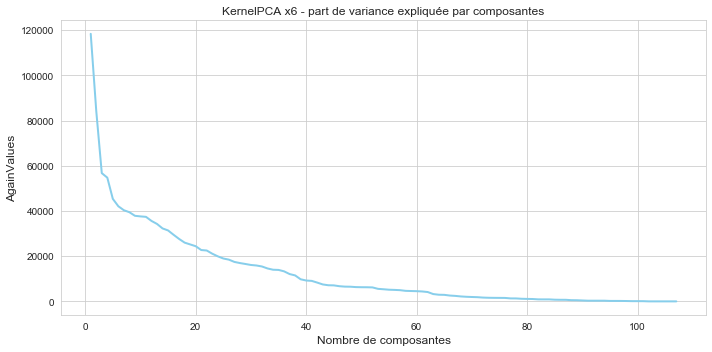

In [48]:
components = range(1, len(kpca_6.lambdas_)+1)
plt.figure(figsize=(10, 5))
plt.plot(components, kpca_6.lambdas_*100, color='skyblue', lw=2)
plt.xlabel('Nombre de composantes', fontsize=12)
plt.ylabel('AgainValues', fontsize=12)
plt.title('KernelPCA x6 - part de variance expliquée par composantes')
plt.tight_layout()
plt.show()

In [49]:
X_6_kpca_projected = kpca_projected(10, X_6)

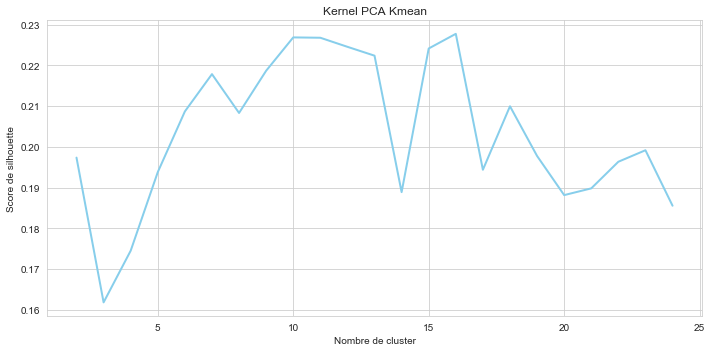

In [50]:
best_cluster_kmean(X_6_kpca_projected, "Kernel PCA")

In [51]:
data_6_months['cluster_kpca_km'] = kmean_labels(16, X_6_kpca_projected)

#### 7.2.2 - 9 mois

In [ ]:
kpca_9 = decomposition.KernelPCA(n_components=X_9.shape[1], kernel="cosine")
kpca_9.fit(X_9)

In [ ]:
components = range(1, len(kpca_9.lambdas_)+1)
plt.figure(figsize=(10, 5))
plt.plot(components, kpca_9.lambdas_*100, color='skyblue', lw=2)
plt.xlabel('Nombre de composantes', fontsize=12)
plt.ylabel('AgainValues', fontsize=12)
plt.title('KernelPCA x9 - part de variance expliquée par composantes')
plt.tight_layout()
plt.show()

In [ ]:
X_9_kpca_projected = kpca_projected(?, X_9)

In [ ]:
best_cluster_kmean(X_9_kpca_projected, "Kernel PCA")

In [ ]:
data_9_months['cluster_kpca_km'] = kmean_labels(?, X_9_kpca_projected)

#### 7.2.3 - 12 mois

In [ ]:
kpca_12 = decomposition.KernelPCA(n_components=X_12.shape[1], kernel="cosine")
kpca_12.fit(X_12)

In [ ]:
components = range(1, len(kpca_12.lambdas_)+1)
plt.figure(figsize=(10, 5))
plt.plot(components, kpca_12.lambdas_*100, color='skyblue', lw=2)
plt.xlabel('Nombre de composantes', fontsize=12)
plt.ylabel('AgainValues', fontsize=12)
plt.title('KernelPCA x12 - part de variance expliquée par composantes')
plt.tight_layout()
plt.show()

In [ ]:
X_12_kpca_projected = kpca_projected(?, X_12)

In [ ]:
best_cluster_kmean(X_12_kpca_projected, "Kernel PCA")

In [ ]:
data_12_months['cluster_kpca_km'] = kmean_labels(?, X_12_kpca_projected)

#### 7.2.4 - 15 mois

In [ ]:
kpca_15 = decomposition.KernelPCA(n_components=X_15.shape[1], kernel="cosine")
kpca_15.fit(X_15)

In [ ]:
components = range(1, len(kpca_15.lambdas_)+1)
plt.figure(figsize=(10, 5))
plt.plot(components, kpca_15.lambdas_*100, color='skyblue', lw=2)
plt.xlabel('Nombre de composantes', fontsize=12)
plt.ylabel('AgainValues', fontsize=12)
plt.title('KernelPCA x15 - part de variance expliquée par composantes')
plt.tight_layout()
plt.show()

In [ ]:
X_15_kpca_projected = kpca_projected(?, X_15)

In [ ]:
best_cluster_kmean(X_15_kpca_projected, "Kernel PCA")

In [ ]:
data_15_months['cluster_kpca_km'] = kmean_labels(?, X_15_kpca_projected)

#### 7.2.5 - 18 mois

In [ ]:
kpca_18 = decomposition.KernelPCA(n_components=X_18.shape[1], kernel="cosine")
kpca_18.fit(X_18)

In [ ]:
components = range(1, len(kpca_18.lambdas_)+1)
plt.figure(figsize=(10, 5))
plt.plot(components, kpca_18.lambdas_*100, color='skyblue', lw=2)
plt.xlabel('Nombre de composantes', fontsize=12)
plt.ylabel('AgainValues', fontsize=12)
plt.title('KernelPCA x18 - part de variance expliquée par composantes')
plt.tight_layout()
plt.show()

In [ ]:
X_18_kpca_projected = kpca_projected(?, X_18)

In [ ]:
best_cluster_kmean(X_18_kpca_projected, "Kernel PCA")

In [ ]:
data_18_months['cluster_kpca_km'] = kmean_labels(?, X_18_kpca_projected)

#### 7.2.6 - all

In [ ]:
kpca_all = decomposition.KernelPCA(n_components=X_all.shape[1], kernel="cosine")
kpca_all.fit(X_all)

In [ ]:
components = range(1, len(kpca_all.lambdas_)+1)
plt.figure(figsize=(10, 5))
plt.plot(components, kpca_all.lambdas_*100, color='skyblue', lw=2)
plt.xlabel('Nombre de composantes', fontsize=12)
plt.ylabel('AgainValues', fontsize=12)
plt.title('KernelPCA x18 - part de variance expliquée par composantes')
plt.tight_layout()
plt.show()

In [ ]:
X_all_kpca_projected = kpca_projected(?, X_all)

In [ ]:
best_cluster_kmean(X_all_kpca_projected, "Kernel PCA")

In [ ]:
data_all_months['cluster_kpca_km'] = kmean_labels(?, X_all_kpca_projected)

## 8 - Analyse des résultats

In [ ]:
data_result['cluster_6_months'] = data_6_months['cluster_kpca_km']
data_result['cluster_9_months'] = data_9_months['cluster_kpca_km']
data_result['cluster_12_months'] = data_12_months['cluster_kpca_km']
data_result['cluster_15_months'] = data_15_months['cluster_kpca_km']
data_result['cluster_18_months'] = data_18_months['cluster_kpca_km']
data_result['cluster_all'] = data_all['cluster_kpca_km']

In [ ]:
data_result

In [ ]:
data_based_3_months = data_result[:][data_result["cluster_3_months"].notnull()]

In [ ]:
data_frequency = pd.DataFrame(index=["AMI Score", 'AR Score'])

In [ ]:
AMI_3_months = metrics.adjusted_mutual_info_score(data_based_3_months["cluster_3_months"], 
                                                  data_based_3_months["cluster_3_months"], 
                                                  average_method='arithmetic')
AR_3_months = metrics.adjusted_rand_score(data_based_3_months["cluster_3_months"], 
                                          data_based_3_months["cluster_3_months"])
NMI_3_months = metrics.normalized_mutual_info_score(data_based_3_months["cluster_3_months"], 
                                                    data_based_3_months["cluster_3_months"], 
                                                    average_method='arithmetic')


AMI_6_months = metrics.adjusted_mutual_info_score(data_based_3_months["cluster_3_months"], 
                                                  data_based_3_months["cluster_6_months"], 
                                                  average_method='arithmetic')
AR_6_months = metrics.adjusted_rand_score(data_based_3_months["cluster_3_months"], 
                                          data_based_3_months["cluster_6_months"])
NMI_6_months = metrics.normalized_mutual_info_score(data_based_3_months["cluster_3_months"], 
                                                    data_based_3_months["cluster_6_months"], 
                                                    average_method='arithmetic')


AMI_9_months = metrics.adjusted_mutual_info_score(data_based_3_months["cluster_3_months"],
                                                  data_based_3_months["cluster_9_months"], 
                                                  average_method="arithmetic")
AR_9_months = metrics.adjusted_rand_score(data_based_3_months["cluster_3_months"], 
                                          data_based_3_months["cluster_9_months"])
NMI_9_months = metrics.normalized_mutual_info_score(data_based_3_months["cluster_3_months"], 
                                                    data_based_3_months["cluster_9_months"], 
                                                    average_method='arithmetic')


AMI_12_months = metrics.adjusted_mutual_info_score(data_based_3_months["cluster_3_months"],
                                                   data_based_3_months["cluster_12_months"],
                                                   average_method="arithmetic")
AR_12_months = metrics.adjusted_rand_score(data_based_3_months["cluster_3_months"], 
                                           data_based_3_months["cluster_12_months"])
NMI_12_months = metrics.normalized_mutual_info_score(data_based_3_months["cluster_3_months"], 
                                                    data_based_3_months["cluster_12_months"], 
                                                    average_method='arithmetic')

AMI_15_months = metrics.adjusted_mutual_info_score(data_based_3_months["cluster_3_months"],
                                                   data_based_3_months["cluster_15_months"],
                                                   average_method="arithmetic")
AR_15_months = metrics.adjusted_rand_score(data_based_3_months["cluster_3_months"], 
                                           data_based_3_months["cluster_15_months"])
NMI_15_months = metrics.normalized_mutual_info_score(data_based_3_months["cluster_3_months"], 
                                                    data_based_3_months["cluster_15_months"], 
                                                    average_method='arithmetic')


AMI_18_months = metrics.adjusted_mutual_info_score(data_based_3_months["cluster_3_months"],
                                                   data_based_3_months["cluster_18_months"],
                                                   average_method="arithmetic")
AR_18_months = metrics.adjusted_rand_score(data_based_3_months["cluster_3_months"], 
                                           data_based_3_months["cluster_18_months"])
NMI_18_months = metrics.normalized_mutual_info_score(data_based_3_months["cluster_3_months"], 
                                                    data_based_3_months["cluster_18_months"], 
                                                    average_method='arithmetic')


AMI_all = metrics.adjusted_mutual_info_score(data_based_3_months["cluster_3_months"],
                                             data_based_3_months["cluster_all"],
                                             average_method="arithmetic")
AR_all = metrics.adjusted_rand_score(data_based_3_months["cluster_3_months"], 
                                     data_based_3_months["cluster_all"])
NMI_all = metrics.normalized_mutual_info_score(data_based_3_months["cluster_3_months"], 
                                                    data_based_3_months["cluster_all"], 
                                                    average_method='arithmetic')

In [ ]:
data_frequency.loc["AMI Score", "cluster_3_months"] = AMI_3_months
data_frequency.loc["AMI Score","cluster_6_months"] = AMI_6_months
data_frequency.loc["AMI Score","cluster_9_months"] = AMI_9_months
data_frequency.loc["AMI Score","cluster_12_months"] = AMI_12_months
data_frequency.loc["AMI Score","cluster_15_months"] = AMI_15_months
data_frequency.loc["AMI Score","cluster_18_months"] = AMI_18_months
data_frequency.loc["AMI Score","cluster_all"] = AMI_all

data_frequency.loc["AR Score", "cluster_3_months"] = AR_3_months
data_frequency.loc["AR Score", "cluster_6_months"] = AR_6_months
data_frequency.loc["AR Score", "cluster_9_months"] = AR_9_months
data_frequency.loc["AR Score", "cluster_12_months"] = AR_12_months
data_frequency.loc["AR Score", "cluster_15_months"] = AR_15_months
data_frequency.loc["AR Score", "cluster_18_months"] = AR_18_months
data_frequency.loc["AR Score", "cluster_all"] = AR_all

data_frequency.loc["NMI Score", "cluster_3_months"] = NMI_3_months
data_frequency.loc["NMI Score", "cluster_6_months"] = NMI_6_months
data_frequency.loc["NMI Score", "cluster_9_months"] = NMI_9_months
data_frequency.loc["NMI Score", "cluster_12_months"] = NMI_12_months
data_frequency.loc["NMI Score", "cluster_15_months"] = NMI_15_months
data_frequency.loc["NMI Score", "cluster_18_months"] = NMI_18_months
data_frequency.loc["NMI Score", "cluster_all"] = NMI_all

data_frequency.loc["# Cluster", "cluster_3_months"] = 8
data_frequency.loc["# Cluster", "cluster_6_months"] = 
data_frequency.loc["# Cluster", "cluster_9_months"] = 
data_frequency.loc["# Cluster", "cluster_12_months"] = 
data_frequency.loc["# Cluster", "cluster_15_months"] = 
data_frequency.loc["# Cluster", "cluster_18_months"] = 
data_frequency.loc["# Cluster", "cluster_all"] = 

In [ ]:
data_frequency